In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from warnings import filterwarnings

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [5]:
df = pd.read_csv('AA.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1962-01-02,6.532155,6.556185,6.532155,6.532155,1.536658,55900
1,1962-01-03,6.532155,6.632280,6.524145,6.632280,1.560212,74500
2,1962-01-04,6.632280,6.664320,6.632280,6.632280,1.560212,80500
3,1962-01-05,6.632280,6.656310,6.616260,6.624270,1.558326,70500
4,1962-01-08,6.608250,6.608250,6.339915,6.408000,1.507450,93800


In [6]:
df = df[['Date', 'Open']] # predict the opening price
df.head()

,Date,Open
0,1962-01-02,6.532155
1,1962-01-03,6.532155
2,1962-01-04,6.632280
3,1962-01-05,6.632280
4,1962-01-08,6.608250


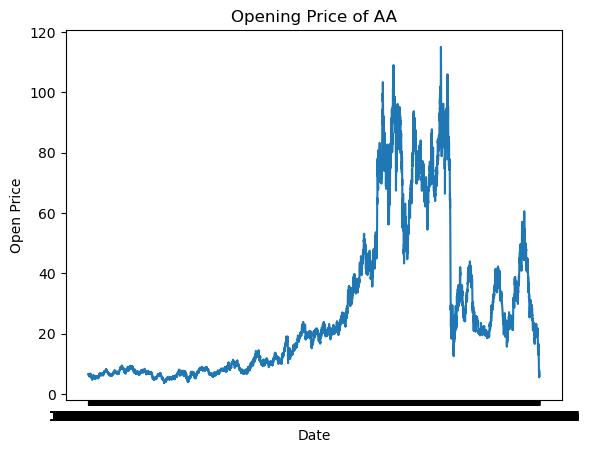

In [7]:
plt.xlabel('Date')
plt.ylabel('Open Price')
plt.title('Opening Price of AA')
plt.plot(df['Date'], df['Open'])
plt.show()

# Data Preprocessing

In [136]:
from sklearn.preprocessing import MinMaxScaler

# Convert the 'Date' column to datetime
df['Date'] = pd.to_datetime(df['Date'])

# Sort by date
df.sort_values(by='Date', inplace=True)

df.head()

,Date,Open
0,1962-01-02,6.532155
1,1962-01-03,6.532155
2,1962-01-04,6.632280
3,1962-01-05,6.632280
4,1962-01-08,6.608250


Organizing the data into input-output pairs for a sequence prediction task

Ví dụ ta có time-series dataset như sau:
| Date       | Open     |
|------------|----------|
| 1962-01-02 | 6.532155 |
| 1962-01-03 | 6.532155 |
| 1962-01-04 | 6.632280 |
| 1962-01-05 | 6.632280 |
| 1962-01-08 | 6.608250 |

Ta muốn dự đoán giá chứng khoán cho ngày kế tiếp dựa trên n = 3 ngày trước đó.

Lúc này ta sẽ tổ chức các cặp input-output như sau:
- Mỗi input sequence sẽ chứa giá chứng khoán của n ngày liên tiếp.
    - Ví dụ [6.532155, 6.532155, 6.632280] là giá chứng khoán của 3 ngày liên tiếp 1962-01-02, 1962-01-03, 1962-01-04
- Output: giá chứng khoán của ngày kế tiếp sau cái ngày cuối cùng trong dãy input sequence trên
    - Ví dụ [6.532155, 6.532155, 6.632280] thì output sẽ là 6.632280 (1962-01-05)

In [137]:
df['Open'].values

array([6.53215504, 6.53215504, 6.63227987, ..., 6.55000019, 6.15999985,
       5.96000004])

In [138]:
num_past_days = 30  # Number of past observations

def create_input_and_output_sequences(data, sequence_len):
    input_sequences = []
    output_sequences = []
    for i in range(len(data) - sequence_len):
        input_seq = data[i:i+sequence_len]
        output_seq = data[i+sequence_len]
        input_sequences.append(input_seq)
        output_sequences.append(output_seq)
    return (input_sequences, output_sequences)

(input_sequences, output_sequences) = create_input_and_output_sequences(df['Open'].values, num_past_days)

# Convert sequences to PyTorch tensors
input_sequences = torch.tensor(input_sequences).float()
output_sequences = torch.tensor(output_sequences).float()

In [139]:
print("input_sequences shape:", input_sequences.shape)
print("output_sequences shape:", output_sequences.shape)

input_sequences shape: torch.Size([14633, 30])
output_sequences shape: torch.Size([14633])


Trong bài toán này, ta chỉ tập trung vào 1 feature là open price

In [140]:
X = np.reshape(a=input_sequences, newshape=(input_sequences.shape[0], input_sequences.shape[1], 1))
y = np.reshape(a=output_sequences, newshape=(output_sequences.shape[0], 1))

In [141]:
print("X shape:", X.shape) # (number of samples or sequences, length of each sequence (number of time steps), number of features at each time step within the sequence)
print("y shape:", y.shape) # (number of samples or sequences, 1)

X shape: torch.Size([14633, 30, 1])
y shape: torch.Size([14633, 1])


In [142]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [143]:
from torch.utils.data import DataLoader, TensorDataset

train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

batch_size = 64 # Số lượng sample mỗi batch
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Stacked LSTM

In [144]:
class StackedLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(StackedLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm1 = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.lstm2 = nn.LSTM(hidden_size, hidden_size, num_layers, batch_first=True)

        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device) # initial hidden state
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device) # initial cell state

        out, _ = self.lstm1(x, (h0, c0))
        out, _ = self.lstm2(out, (h0, c0))

        out = self.fc(out[:, -1, :]) # get last hidden state and pass it through the fully connected layer
        return out

In [145]:
input_size = X_train.shape[2] # the number of features in the input data at each time step
hidden_size = 64 # the number of neurons in each LSTM layer
num_layers = 2 # Số lượng LSTM layer
output_size = 1 # Regression

model = StackedLSTM(input_size, hidden_size, num_layers, output_size).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

print(model)

StackedLSTM(
  (lstm1): LSTM(1, 64, num_layers=2, batch_first=True)
  (lstm2): LSTM(64, 64, num_layers=2, batch_first=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)


In [146]:
num_epochs = 20
stacked_lstm_train_losses = []
for epoch in range(num_epochs):
    epoch_loss = 0.0
    for batch_index, batch in enumerate(train_loader):
        batch_X, batch_y = batch[0].to(device), batch[1].to(device)
        
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * batch_size  # Multiply by batch size to get total loss in the epoch
    epoch_loss /= len(train_loader.dataset)  # Calculate average loss per sample
    stacked_lstm_train_losses.append(epoch_loss)
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [1/20], Loss: 931.0219
Epoch [2/20], Loss: 405.2767
Epoch [3/20], Loss: 492.2393
Epoch [4/20], Loss: 584.6591
Epoch [5/20], Loss: 565.5190
Epoch [6/20], Loss: 641.0477
Epoch [7/20], Loss: 470.1325
Epoch [8/20], Loss: 139.0381
Epoch [9/20], Loss: 148.0585
Epoch [10/20], Loss: 69.5413
Epoch [11/20], Loss: 83.2458
Epoch [12/20], Loss: 13.4692
Epoch [13/20], Loss: 36.3479
Epoch [14/20], Loss: 6.0402
Epoch [15/20], Loss: 5.5992
Epoch [16/20], Loss: 4.9169
Epoch [17/20], Loss: 2.1442
Epoch [18/20], Loss: 6.5265
Epoch [19/20], Loss: 2.0014
Epoch [20/20], Loss: 9.6796


In [147]:
model.eval()
with torch.no_grad():
    total_loss = 0.0
    num_samples = 0
    for batch_X, batch_y in test_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        total_loss += loss.item() * batch_X.size(0)  # Accumulate the total loss
        num_samples += batch_X.size(0)

    # Calculate average test loss
    avg_loss = total_loss / num_samples
    print(f'Average test loss: {avg_loss:.4f}')

Average test loss: 3.5124


# Bidirectional LSTM

It processes the input sequence in both forward and backward directions

In [148]:
class BidirectionalLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(BidirectionalLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_size * 2, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(x.device) # initial hidden state
        c0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(x.device) # initial cell state

        out, _ = self.lstm(x, (h0, c0)) # output contains both the forward and backward hidden states at each time step
        out = self.fc(out[:, -1, :])
        
        return out

In [149]:
input_size = X_train.shape[2] # the number of features in the input data at each time step
hidden_size = 64 # the number of neurons in each LSTM layer
num_layers = 1 # Số lượng LSTM layer
output_size = 1 # Regression

model = BidirectionalLSTM(input_size, hidden_size, num_layers, output_size).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

print(model)

BidirectionalLSTM(
  (lstm): LSTM(1, 64, batch_first=True, bidirectional=True)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)


In [150]:
num_epochs = 20
bidirectional_lstm_train_losses = []
for epoch in range(num_epochs):
    epoch_loss = 0.0
    for batch_index, batch in enumerate(train_loader):
        batch_X, batch_y = batch[0].to(device), batch[1].to(device)
        
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item() * batch_size  # Multiply by batch size to get total loss in the epoch
    epoch_loss /= len(train_loader.dataset)  # Calculate average loss per sample
    bidirectional_lstm_train_losses.append(epoch_loss)
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

Epoch [1/20], Loss: 506.1655
Epoch [2/20], Loss: 141.4358
Epoch [3/20], Loss: 189.4006
Epoch [4/20], Loss: 79.9476
Epoch [5/20], Loss: 40.1023
Epoch [6/20], Loss: 5.8571
Epoch [7/20], Loss: 11.7210
Epoch [8/20], Loss: 9.4705
Epoch [9/20], Loss: 2.3733
Epoch [10/20], Loss: 2.3918
Epoch [11/20], Loss: 2.3070
Epoch [12/20], Loss: 1.6456
Epoch [13/20], Loss: 9.8003
Epoch [14/20], Loss: 1.3378
Epoch [15/20], Loss: 2.6690
Epoch [16/20], Loss: 1.4115
Epoch [17/20], Loss: 0.4022
Epoch [18/20], Loss: 0.8271
Epoch [19/20], Loss: 0.7733
Epoch [20/20], Loss: 0.9868


In [151]:
model.eval()
with torch.no_grad():
    total_loss = 0.0
    num_samples = 0
    for batch_X, batch_y in test_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        total_loss += loss.item() * batch_X.size(0)  # Accumulate the total loss
        num_samples += batch_X.size(0)

    # Calculate average test loss
    avg_loss = total_loss / num_samples
    print(f'Average test loss: {avg_loss:.4f}')

Average test loss: 1.3128


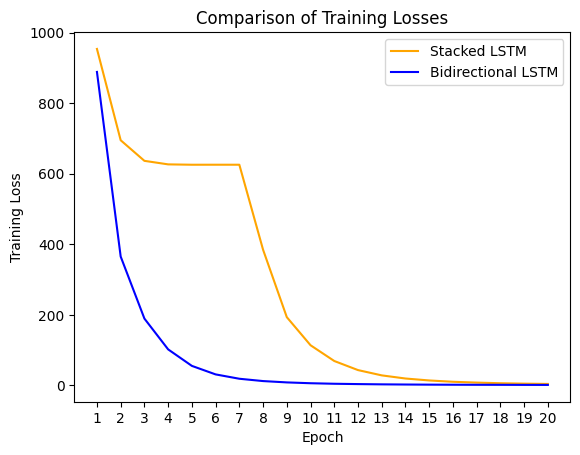

In [156]:
# Plot training losses
epochs = range(1, num_epochs + 1)
plt.plot(epochs, stacked_lstm_train_losses, label='Stacked LSTM', color='orange')
plt.plot(epochs, bidirectional_lstm_train_losses, label='Bidirectional LSTM', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Comparison of Training Losses')
plt.xticks(epochs)
plt.legend()
plt.show()